# Libraries

Simulation data will be analysed using the `OOMMFPy` library https://github.com/davidcortesortuno/oommfpy

In [1086]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import oommfpy as op
import os

from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.interpolate as si

import scipy.interpolate as si
import scipy.optimize as so
import matplotlib

import os

# import matplotlib_scalebar.scalebar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

plt.style.use('styles/dejavu_style.mplstyle')

# Equilibrium states

Plots of the equilibrium states found from relaxing 3 paraboloids:

In [1144]:
omfs = glob.glob('sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/*no-helix*.omf')
for i, o in enumerate(omfs):
    if 'init' in o:
        omfs.pop(i)
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=Bz)\d{3}', f).group(0)))

In [1145]:
omfs

['sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz100mT-Oxs_MinDriver-Magnetization-00-0096361.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz120mT-Oxs_MinDriver-Magnetization-00-0027237.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz130mT-Oxs_MinDriver-Magnetization-00-0018867.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz150mT-Oxs_MinDriver-Magnetization-00-0016822.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz200mT-Oxs_MinDriver-Magnetization-00-0045488.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz250mT-Oxs_MinDriver-Magnetization-00-0032172.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz300mT-Oxs_MinDriver-Magnetization-00-0018230.omf']

In [1151]:
bw_maps = {}

for i, omf in enumerate(omfs): 

    Bz = re.search(r'(?<=Bz)\d{3}', omf).group(0)
    
    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    av_map = np.zeros((len(data.xs), len(data.zs)))
    for j, y in enumerate(data.ys):
        fltr = data.y == data.ys[j]
        av_map += data.field_y[fltr].reshape(len(data.xs), -1)
    av_map /= len(data.ys)
        
    bw_maps[Bz] = np.copy(av_map)

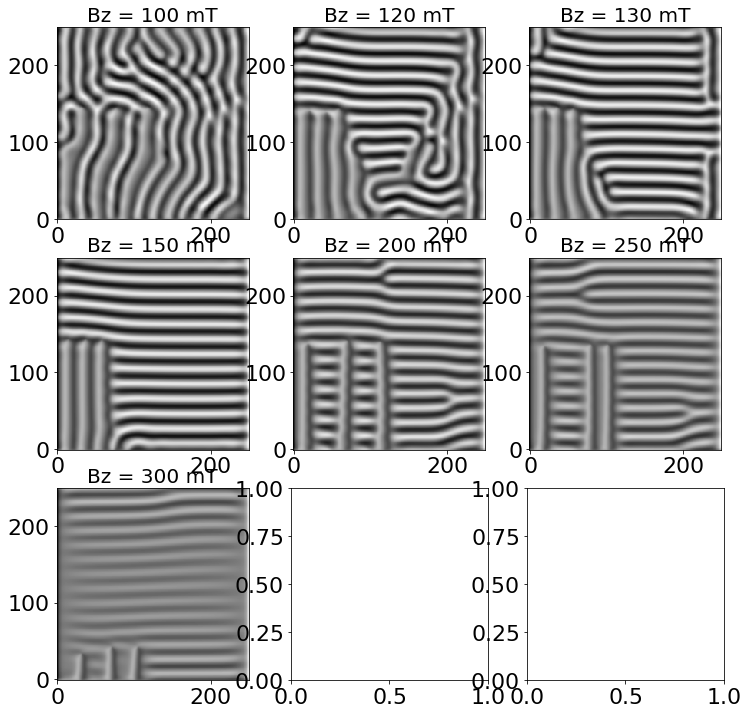

In [1152]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, bz in enumerate(bw_maps.keys()):
    ax = axs.flatten()[i]
    ax.imshow(bw_maps[bz], origin='lower', vmin=-1, vmax=1, cmap='binary')
    ax.set_title('Bz = {} mT'.format(bz))

In [235]:
DIR = 'data_my_sk_tubes_field_sweep_Bzs_init_states_relaxed'
os.makedirs(DIR)

for i, bz in enumerate(bw_maps.keys()):
   
    np.savetxt(DIR + '/m_Bz_{:03d}_mT.txt'.format(int(bz)), bw_maps[bz])

## Init state  

In [256]:
omf ='sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/sk_tubes_FeGe/m_no-helix_Bz300mT_init-Oxs_MinDriver-Magnetization-00-0000000.omf'

data = op.MagnetisationData(omf)
data.generate_coordinates()
data.generate_field()

av_map = np.zeros((len(data.xs), len(data.zs)))
for j, y in enumerate(data.ys):
    fltr = data.y == data.ys[j]
    av_map += data.field_y[fltr].reshape(len(data.xs), -1)
av_map /= len(data.ys)
bw_map = np.copy(av_map)

DIR = 'data_my_sk_tubes_field_sweep_Bzs_init_states_relaxed'
np.savetxt(DIR + '/m_Bz_INIT.txt', bw_map)

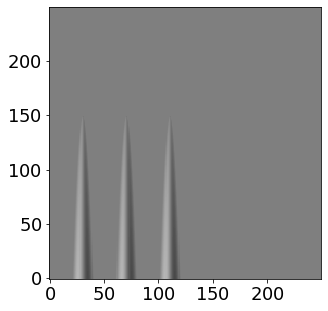

In [257]:
plt.imshow(bw_map, origin='lower', vmin=-1, vmax=1, cmap='binary')

# Field sweep: 150 mT -> 300 mT

Load the simulations files in OMF file format and sort them by the simulation step number. The field sweep in this case was performed in steps of 5 mT starting at 150 mT, so the field at every file is given by `Bz = 150 + i * 5` mT 

In [1161]:
omfs = glob.glob('sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/*.omf')
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=Magnetization-)\d\d', f).group(0)))

In [1162]:
omfs

['sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-00-0000000.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-01-0007575.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-02-0014664.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-03-0021990.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-04-0030782.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-05-0040905.omf',
 'sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/m-Oxs_MinDriver-Magnetization-06-004848

Generate averages of the out of plane component of the magnetisation through the thickness of the sample. The thickness in this case is in the `y` direction, thus we average the `m_y` component. We will save the averages for every field sweep stage

In [1163]:
bw_maps = []

for i, omf in enumerate(omfs): 

    # Load the OMF file from oommf
    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    av_map = np.zeros((len(data.xs), len(data.zs)))
    for j, y in enumerate(data.ys):
        fltr = data.y == data.ys[j]
        av_map += data.field_y[fltr].reshape(len(data.xs), -1)
    av_map /= len(data.ys)
        
    bw_maps.append(np.copy(av_map))

Here we save the component along the skyrmion tubes, `m_z`, at a slice at the middle of the sample thickness (not averaged), and for every satge of the field sweep:

In [1164]:
z_maps = []

for i, omf in enumerate(omfs): 

    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()

    fltr = data.y == data.ys[len(data.ys) // 2]
    z_maps.append(np.copy(data.field_z[fltr].reshape(len(data.xs), -1)))

These are the averages of `m_y` (out of plane) trough the sample thickness for a few field sweep steps:

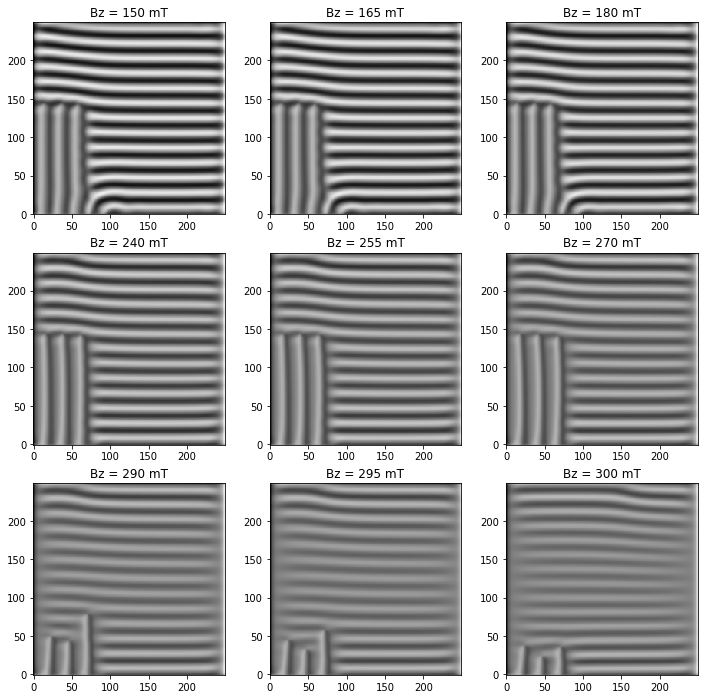

In [292]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for idx, i in enumerate([0, 3, 6, 18, 21, 24, 28, 29, 30]):
    ax = axs.flatten()[idx]
    ax.imshow(bw_maps[i], origin='lower', vmin=-1, vmax=1, cmap='binary')
    ax.set_title('Bz = {} mT'.format(150 + 5 * i))

We save the data:

In [16]:
os.makedirs('data_my_sk_tubes_field_sweep_Bz_150mT_300mT_step_5mT')

for idx, i in enumerate(range(30)):
   
    np.savetxt('data_my_sk_tubes_field_sweep_Bz_150mT_300mT_step_5mT/m_Bz_{}_mT.txt'.format(150 + 5 * i), bw_maps[i])

The same maps but using a slice at the centre of the sample and plotting $m_z$ (component along the sk tubes):

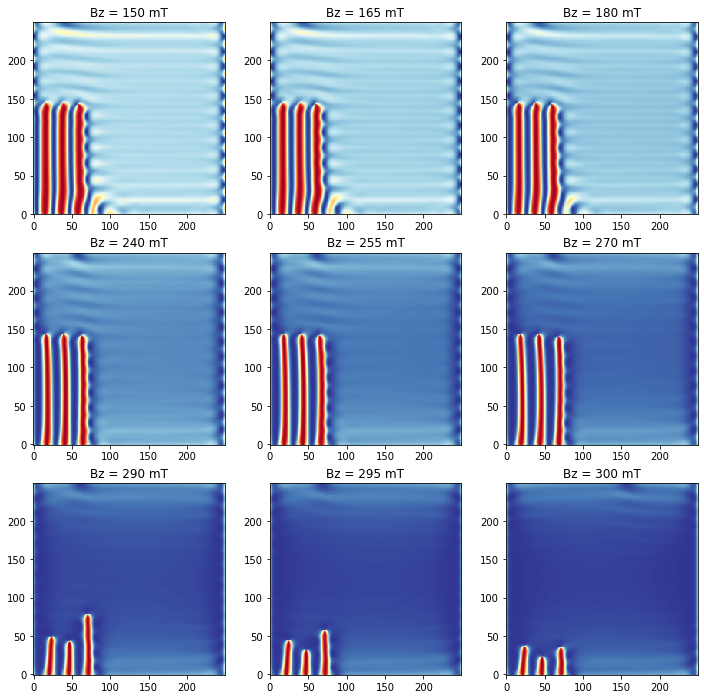

In [12]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for idx, i in enumerate([0, 3, 6, 18, 21, 24, 28, 29, 30]):
    ax = axs.flatten()[idx]
    ax.imshow(z_maps[i], origin='lower', vmin=-1, vmax=1, cmap='RdYlBu')
    ax.set_title('Bz = {} mT'.format(150 + 5 * i))

## Field sweep: BW colormaps

Plot of the averages through the sample thickness

In [1165]:
omfs = glob.glob('sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_300mT_450mT/*.omf')
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=Magnetization-)\d\d', f).group(0)))

bw_maps = []
for i, omf in enumerate(omfs): 

    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    av_map = np.zeros((len(data.xs), len(data.zs)))
    for j, y in enumerate(data.ys):
        fltr = data.y == data.ys[j]
        av_map += data.field_y[fltr].reshape(len(data.xs), -1)
    av_map /= len(data.ys)
        
    bw_maps.append(np.copy(av_map))

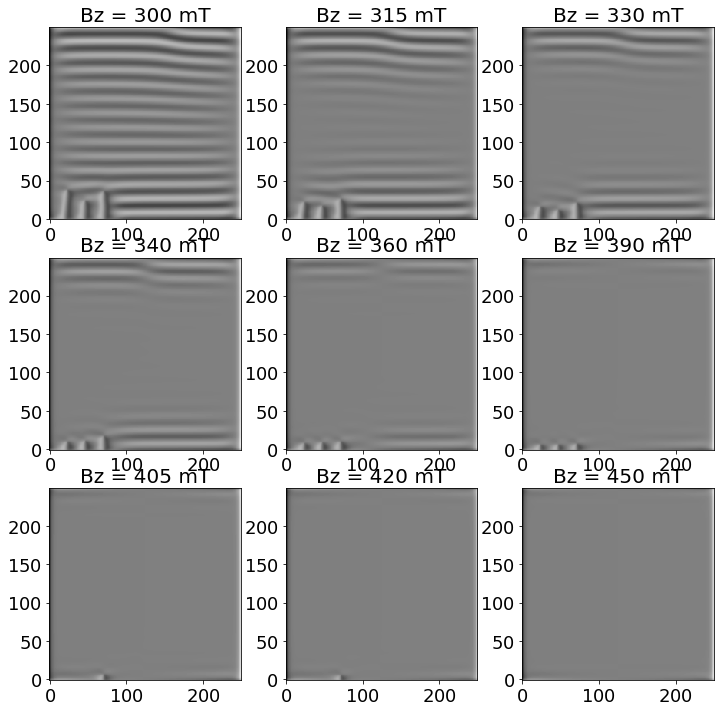

In [847]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for idx, i in enumerate([0, 3, 6, 8, 12, 18, 21, 24, 30]):
    ax = axs.flatten()[idx]
    ax.imshow(bw_maps[i], origin='lower', vmin=-1, vmax=1, cmap='binary')
    ax.set_title('Bz = {} mT'.format(300 + 5 * i))

In [34]:
# os.makedirs('data_my_sk_tubes_field_sweep_Bz_150mT_300mT_step_5mT')
for idx, i in enumerate(range(31)):
    np.savetxt('data_my_sk_tubes_field_sweep_Bz_150mT_300mT_step_5mT/m_By_{}_mT.txt'.format(300 + 5 * i), bw_maps[i])

# Iso surfaces

In [1226]:
omfs = glob.glob('sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/*.omf')
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=Magnetization-)\d\d', f).group(0)))

We can plot isosurfaces in Matplotlib using the `scikit` methods to obtain `m_z` isosurfaces (comp along sk tubes)

In [1132]:
data = op.MagnetisationData(omfs[0])
data.generate_coordinates()
data.generate_field()

In [1133]:
# Reshape the data into a cuboid and then use the marching cubes algorithm to find
# the isosurface in 3D
vol_mz = data.field_z.reshape(len(data.xs), len(data.ys), len(data.zs))
verts, faces, _, _ = measure.marching_cubes_lewiner(vol_mz, 0.2, spacing=(4, 4, 4))

This is how the isosurface looks like (remember `z` is along the sk tube). To show the plot correctly, the `axes3d` file in Matplotlib needs updating

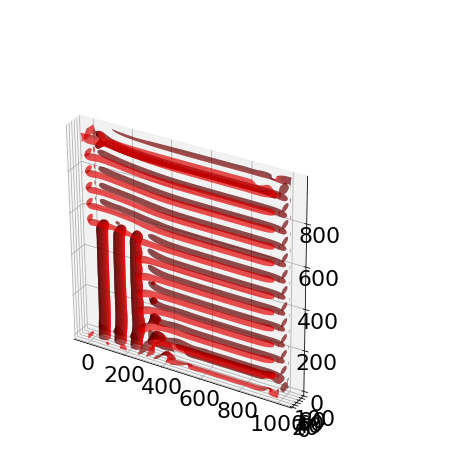

In [1134]:
fig, ax = plt.subplots(ncols=1, nrows=1, subplot_kw=dict(projection='3d'), figsize=(8, 8))

# needs modification of anaconda3/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py
# Check: https://github.com/matplotlib/matplotlib/issues/8593
ax.pbaspect = [1, 0.1, 1]

ax.plot_trisurf(verts[:, 2], verts[:, 1], verts[:, 0], triangles=faces, color='red', lw=1)
 

## Isolines

These plots will show isocontours of constant `m_z` values at Bz = 150 mT. We first show a slice of the system:

In [1194]:
omf_index = 0  # Initial field sweep stage, Bz = 150 mT
data = op.MagnetisationData(omfs[omf_index])
data.generate_coordinates()
data.generate_field()

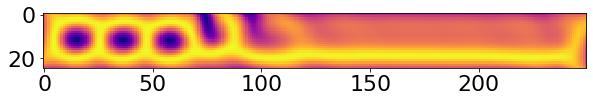

In [1195]:
plt.figure(figsize=(10, 1))
ftr = data.z == data.zs[0]
plt.imshow(data.mz[ftr].reshape(len(data.ys), -1), cmap='plasma', vmin=-1, vmax=1)

We plot a slice of the system with the coordinate axes rotated, i.e. we change `y->z` and `z->y`, thus we invert the `x` coordinates `x->-x`. This way, the `z` coordinate will be along the thickness of the sample, to be consistent with other simulations.

The following plot shows the skyrmion number density `q` (computed with `OOMMFPy`) on top and the `m_y` (new coordinate system) component, which is along the sk tubes now.

Text(0, 0.5, 'z (nm)')

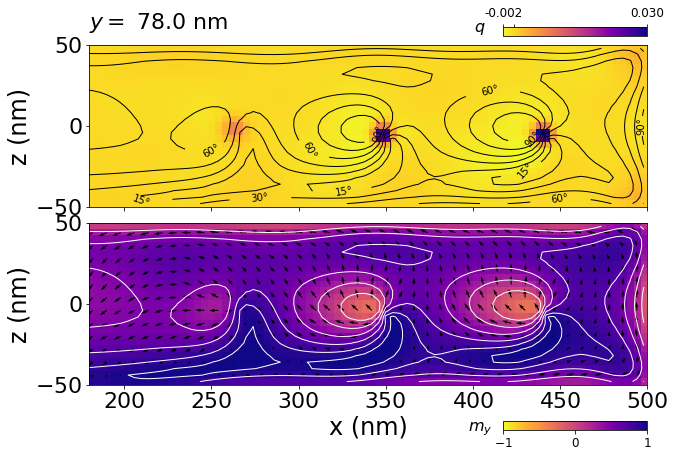

In [1135]:
f, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 2 * 10 / 3.2), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1)
ax = axs.flatten()

z_index = 144
data.compute_sk_number(index=z_index, plane='xy')
ftr = data.z == data.zs[z_index]
minq, maxq = data.sk_number.min(), data.sk_number.max()
# np.max([np.abs(data.sk_number.min()), np.abs(data.sk_number.max())])

ax[0].pcolormesh(-X, -Y, data.sk_number, cmap='plasma_r', 
                vmin=minq, vmax=maxq)

contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(7)]
C = ax[0].contour(-data.xs, -data.ys, 
                data.mz[ftr].reshape(len(data.ys), -1), 
                contours,
                linewidths=1., colors='k')

ax[0].clabel(C, contours[::2] + [contours[-2]],
           inline=1, fontsize=10, inline_spacing=1,
           # Transform the cos into grad angles to be shown:
           fmt=lambda f: '{:.0f}'.format(round(np.arccos(f) * 180 / np.pi)) + u'°'
           )
ax[0].set_xlim(180, 500)
ax[0].set_ylabel('z (nm)')
ax[0].text(0, 1.1, r'$y =$' + f' {data.zs[z_index]:.1f} nm', transform=ax[0].transAxes,  
           fontsize=22)

# colorbar
box = ax[0].get_position()
axCb = plt.axes([box.x1 - 0.2, box.y1 + 0.02, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r, 
                                      orientation="horizontal",
                                      ticks=[minq, 0, maxq],
                                      norm=matplotlib.colors.Normalize(vmin=minq, vmax=maxq))
cb.set_ticklabels([f'{minq:.3f}', '', f'{maxq:.3f}'])
cb.ax.tick_params(labelsize=12) 
cb.set_label(r'$q$', rotation=0, x=-0.16, labelpad=-15, fontsize=16)
axCb.xaxis.set_ticks_position('top')

X = np.array(list(data.xs - 1e9 * 0.5 * data.dx) + [data.xs[-1] + 0.5 * 1e9 * data.dx])
Y = np.array(list(data.ys - 1e9 * 0.5 * data.dy) + [data.ys[-1] + 0.5 * 1e9 * data.dy])
ax[1].pcolormesh(-X, -Y, 
               data.mz[ftr].reshape(len(data.ys), -1), 
               # [-1 + 0.25 * i for i in range(9)],
               # linewidth=1,
               cmap='plasma_r', 
               vmin=-1, vmax=1
               )
contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(7)]
C = ax[1].contour(-data.xs, -data.ys, 
                data.mz[ftr].reshape(len(data.ys), -1), 
                contours,
                linewidths=1., colors='w')

qftr = np.ones_like(data.x[ftr]).astype(np.bool)
qftr.shape = (len(data.ys), -1)
qftr[:, ::2] = False
qftr[::2, :] = False
qftr.shape = (-1,)
ax[1].quiver(-data.x[ftr][qftr], -data.y[ftr][qftr], 
             data.field_x[ftr][qftr], data.field_y[ftr][qftr], 
             scale=0.18, scale_units='xy', width=0.002)

box = ax[1].get_position()
axCb = plt.axes([box.x1 - 0.2, box.y0 - 0.1, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r, 
                                      orientation="horizontal",
                                      ticks=[-1, 0, 1],
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=12) 
cb.set_label(r'$m_y$', rotation=0, x=-0.16, labelpad=-30, fontsize=16)
axCb.xaxis.set_ticks_position('bottom')

ax[1].set_xlabel('x (nm)')
ax[1].set_ylabel('z (nm)')

# plt.savefig(f'sk-num-dens_mz_average_Bz{bz:04d}mT_z-slice{int(data.zs[z_index])}nm.pdf',
#             bbox_inches='tight')

## Isolines and average through sample thickness

The following plot shows the isocontour lines of `m_y` (new coordinate system) at 150 mT. It also shows the average magnetisation (from the `bw_maps` list) at a slice of the tubes. We find the zeros of the average magnetisation value by interpolating this average and using a root finding algorithm

In [1227]:
# Compute the bw_maps:
bw_maps = []
for i, omf in enumerate(omfs): 

    # Load the OMF file from oommf
    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    av_map = np.zeros((len(data.xs), len(data.zs)))
    for j, y in enumerate(data.ys):
        fltr = data.y == data.ys[j]
        av_map += data.field_y[fltr].reshape(len(data.xs), -1)
    av_map /= len(data.ys)
        
    bw_maps.append(np.copy(av_map))

In [1228]:
omf_index = 24
data = op.MagnetisationData(omfs[omf_index])
data.generate_coordinates()
data.generate_field()

Slices at different `y` values can be shown modifying the `z_index` parameter

In [1217]:
plt.style.use('styles/dejavu_style.mplstyle')

zeros [218.6605857840725, 267.0693787167014, 315.977184653503, 365.06942143956337, 414.5848862022749, 464.8699270280933]


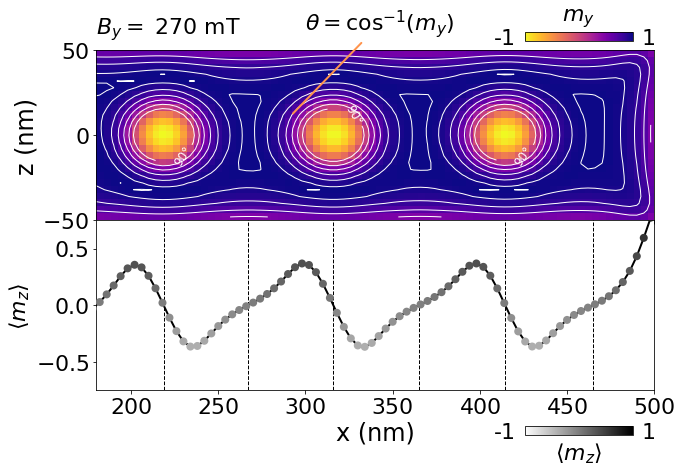

In [1229]:
f, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 2 * 10 / 3.2), sharex=True)
plt.subplots_adjust(hspace=0.)
ax = axs.flatten()
z_index = 50
ftr = data.z == data.zs[z_index]
bz = 150 + 5 * omf_index 

# Plot the contour lines
contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(6)] + [np.cos(np.pi * i / 180) for i in [5, 0]]
C = ax[0].contour(-data.xs, -data.ys, 
                data.mz[ftr].reshape(len(data.ys), -1), 
                contours,
                linewidths=1., colors='w')

# If you want labels:
ax[0].clabel(C, [contours[0]],
             # [np.cos(np.pi * 90 / 180), np.cos(np.pi * 30 / 180)], 
             inline=1, fontsize=12, inline_spacing=1,
             # fmt={np.cos(np.pi * 90 / 180): '0', np.cos(np.pi * 30 / 180): '30'}
             # Transform the cos into grad angles to be shown:
             fmt=lambda f: '{:.0f}'.format(round(np.arccos(f) * 180 / np.pi)) + u'°'
             )

ax[0].annotate(r'$\theta=\cos^{-1} (m_y)$', (292, 12), (300, 62), 
               fontsize=22, arrowprops={'arrowstyle': '-', 'lw': 2, 'color': '#ff944d'})

ax[0].text(0, 1.1, r'$B_y =$' + ' {} mT'.format(bz), transform=ax[0].transAxes,  
           fontsize=22)

# colorbar
box = ax[0].get_position()
axCb = plt.axes([box.x1 - 0.18, box.y1 + 0.02, 0.15, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r, 
                                      orientation="horizontal",
                                      ticks=[],
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=18) 
cb.set_label(r'$m_{y}$', rotation=0, x=0.5, labelpad=-35, fontsize=22)
axCb.xaxis.set_ticks_position('top')
cb.set_ticklabels([])
cb.ax.text(-0.08, 0.3, str(-1), transform=cb.ax.transAxes, va='center', ha='right', fontsize=22)
cb.ax.text(1.08, 0.3, str(1), transform=cb.ax.transAxes, va='center', ha='left', fontsize=22)

# plt.contourf(-data.xs, -data.ys, 
#              data.mz[ftr].reshape(len(data.ys), -1), 
#              [-1 + 0.25 * i for i in range(9)],
#              linewidth=1,
#              cmap='plasma', vmin=-1, vmax=1)

# pcolormesh uses the coordinates of the corners of the grid, so we must shift the
# cell centers by (dx / 2)
X = np.array(list(data.xs - 1e9 * 0.5 * data.dx) + [data.xs[-1] + 0.5 * 1e9 * data.dx])
Y = np.array(list(data.ys - 1e9 * 0.5 * data.dy) + [data.ys[-1] + 0.5 * 1e9 * data.dy])
ax[0].pcolormesh(-X, -Y, 
               data.mz[ftr].reshape(len(data.ys), -1), 
               # [-1 + 0.25 * i for i in range(9)],
               # linewidth=1,
               cmap='plasma_r', vmin=-1, vmax=1)

ax[0].set_xlim(180, 500)
ax[0].set_ylim(-50, 50)
ax[0].set_ylabel('z (nm)')

# Show the Average of out of plane component

# We start finding the zeros of the out of plane component, by interpolating the data
mz_int = si.interp1d(-data.xs, bw_maps[omf_index][z_index])
zeros = []
# Find possible zeros analysing chunks of 50 mT of data
a = np.linspace(200, 490, 50)
for i, x in enumerate(a):
    try:
        zeros.append(so.brentq(mz_int, a[i], a[i + 1]))
    except: 
        pass
print('zeros', zeros)

# Plot the averages
ax[1].plot(-data.xs, bw_maps[omf_index][z_index], '-', c='k', lw=2, zorder=1)
ax[1].scatter(-data.xs, bw_maps[omf_index][z_index],
              c=bw_maps[omf_index][z_index],
              # 'o-', c='#100788', 
              lw=2,
              cmap='binary', vmin=-1, vmax=1, zorder=10
              )
ax[1].set_ylabel(r'$\langle m_{z} \rangle$', fontsize=22)

# plot all the zeros at vertical lines
for z in zeros:
    ax[1].axvline(x=z, lw=1, color='k', ls='--')

ax[1].set_xlabel('x (nm)')
ax[1].set_ylim(-0.75, 0.75)

# Colorbar of <m_z>
box = ax[1].get_position()
axCb = plt.axes([box.x1 - 0.18, box.y0 - 0.1, 0.15, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.binary, 
                                              orientation="horizontal",
                                              ticks=[],
                                              norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=18) 
cb.set_label(r'$\langle m_z \rangle$', rotation=0, x=0.5, labelpad=5, fontsize=22)
axCb.xaxis.set_ticks_position('bottom')
cb.set_ticklabels([])
cb.ax.text(-0.08, 0.3, str(-1), transform=cb.ax.transAxes, va='center', ha='right', fontsize=22)
cb.ax.text(1.08, 0.3, str(1), transform=cb.ax.transAxes, va='center', ha='left', fontsize=22)

plt.savefig(f'isolines_mz_average_Bz{bz:04d}mT_z-slice{int(data.zs[z_index])}nm.pdf',
            bbox_inches='tight')

plt.show()

We can see that the zeros of the averages match nicely with the skyrmion centers. 

Now we plot the same but at a higher field, 280 mT. We start loading the corresponding field sweep stage file:

In [1137]:
omf_index = 26  # 280 = 150 + 
26 * 5
data = op.MagnetisationData(omfs[omf_index])
data.generate_coordinates()
data.generate_field()

zeros [214.39960521898513, 268.4939933476006, 314.8869224440877, 372.2788012268407, 415.7392650165224, 475.8457923824863]


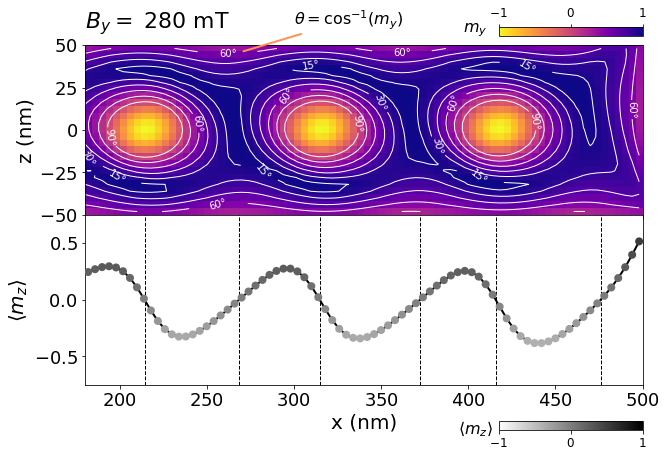

In [613]:
f, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 2 * 10 / 3.2), sharex=True)
plt.subplots_adjust(hspace=0.)
ax = axs.flatten()
z_index = 0
ftr = data.z == data.zs[z_index]
bz = 150 + 5 * omf_index 

# plt.imshow(data.mz[ftr].reshape(len(data.ys), -1),
#            extent=[data.xs[0] - 1e9 * data.dx * 0.5, data.xs[-1] + 1e9 * data.dx * 0.5, 
#                    data.ys[0] - 1e9 * data.dy * 0.5, data.ys[-1] + 1e9 * data.dy * 0.5],
#            cmap='plasma', vmin=-1, vmax=1, aspect='auto', origin='lower')

contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(7)]
C = ax[0].contour(-data.xs, -data.ys, 
                data.mz[ftr].reshape(len(data.ys), -1), 
                contours,
                linewidths=1., colors='w')

ax[0].clabel(C, contours[::2] + [contours[-2]],
           # [np.cos(np.pi * 90 / 180), np.cos(np.pi * 30 / 180)], 
           inline=1, fontsize=10, inline_spacing=1,
           # fmt={np.cos(np.pi * 90 / 180): '0', np.cos(np.pi * 30 / 180): '30'}
           # Transform the cos into grad angles to be shown:
           fmt=lambda f: '{:.0f}'.format(round(np.arccos(f) * 180 / np.pi)) + u'°'
           )

ax[0].annotate(r'$\theta=\cos^{-1} (m_y)$', (270, 46), (300, 62), 
               fontsize=16, arrowprops={'arrowstyle': '-', 'lw': 2, 'color': '#ff944d'})

ax[0].text(0, 1.1, r'$B_y =$' + ' {} mT'.format(bz), transform=ax[0].transAxes,  
           fontsize=22)

# colorbar
box = ax[0].get_position()
axCb = plt.axes([box.x1 - 0.2, box.y1 + 0.02, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r, 
                                      orientation="horizontal",
                                      ticks=[-1, 0, 1],
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=12) 
cb.set_label(r'$m_{y}$', rotation=0, x=-0.16, labelpad=-15, fontsize=16)
axCb.xaxis.set_ticks_position('top')

# plt.contourf(-data.xs, -data.ys, 
#              data.mz[ftr].reshape(len(data.ys), -1), 
#              [-1 + 0.25 * i for i in range(9)],
#              linewidth=1,
#              cmap='plasma', vmin=-1, vmax=1)

# pcolormesh uses the coordinates of the corners of the grid, so we must shift the
# cell centers by (dx / 2)
X = np.array(list(data.xs - 1e9 * 0.5 * data.dx) + [data.xs[-1] + 0.5 * 1e9 * data.dx])
Y = np.array(list(data.ys - 1e9 * 0.5 * data.dy) + [data.ys[-1] + 0.5 * 1e9 * data.dy])
ax[0].pcolormesh(-X, -Y, 
               data.mz[ftr].reshape(len(data.ys), -1), 
               # [-1 + 0.25 * i for i in range(9)],
               # linewidth=1,
               cmap='plasma_r', vmin=-1, vmax=1)

ax[0].set_xlim(180, 500)
ax[0].set_ylim(-50, 50)

ax[0].set_ylabel('z (nm)')

# Avergae of out of plane component

mz_int = si.interp1d(-data.xs, bw_maps[omf_index][z_index])
zeros = []
a = np.linspace(200, 490, 50)
for i, x in enumerate(a):
    try:
        zeros.append(so.brentq(mz_int, a[i], a[i + 1]))
    except: 
        pass
print('zeros', zeros)

ax[1].plot(-data.xs, bw_maps[omf_index][z_index], '-', c='k', lw=2, zorder=1)
ax[1].scatter(-data.xs, bw_maps[omf_index][z_index],
              c=bw_maps[omf_index][z_index],
              # 'o-', c='#100788', 
              lw=2,
              cmap='binary', vmin=-1, vmax=1, zorder=10
              )
ax[1].set_ylabel(r'$\langle m_{z} \rangle$', fontsize=20)
for z in zeros:
    ax[1].axvline(x=z, lw=1, color='k', ls='--')

ax[1].set_xlabel('x (nm)')
ax[1].set_ylim(-0.75, 0.75)

box = ax[1].get_position()
axCb = plt.axes([box.x1 - 0.2, box.y0 - 0.1, 0.2, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.binary, 
                                      orientation="horizontal",
                                      ticks=[-1, 0, 1],
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=12) 
cb.set_label(r'$\langle m_z \rangle$', rotation=0, x=-0.16, labelpad=-30, fontsize=16)
axCb.xaxis.set_ticks_position('bottom')

plt.savefig(f'isolines_mz_average_Bz{bz:04d}mT_z-slice{int(data.zs[z_index])}nm.pdf',
            bbox_inches='tight')

plt.show()

# Publication plot

Here we plot one of the grpahs shown in the paper. These are, slices showing the `m_y` component (along the tubes, so we have to rotate the coordinates, remember the original data has `z` along the tube) aat two fields: 280 mT and 150 mT, at a slice 50 mT away fromt he skyrmion surfaces. then 3 extra plots with the skyrmion number density `q`, at a field of 150 mT, at 3 slices: at the middle of a sk tube, before the Bloch point and after the Bloch point

In [1082]:
# Use a specific style for the plot (custom font sizes)
plt.style.use('styles/dejavu_style.mplstyle')

zeros [213.18556891969953, 262.2725806160763, 313.13714381637436, 361.91584596435916, 413.79815875369945, 463.2250248118431]
zeros [222.70744847648132, 262.83370435028434, 306.5012651939425, 350.1271784395627, 392.609409813635, 437.1699050453846, 477.9196765851718]
z_i = 12 q_sk= -3.04513606533
z_i = 143 q_sk= -1.37669303659
z_i = 144 q_sk= 0.12469952946


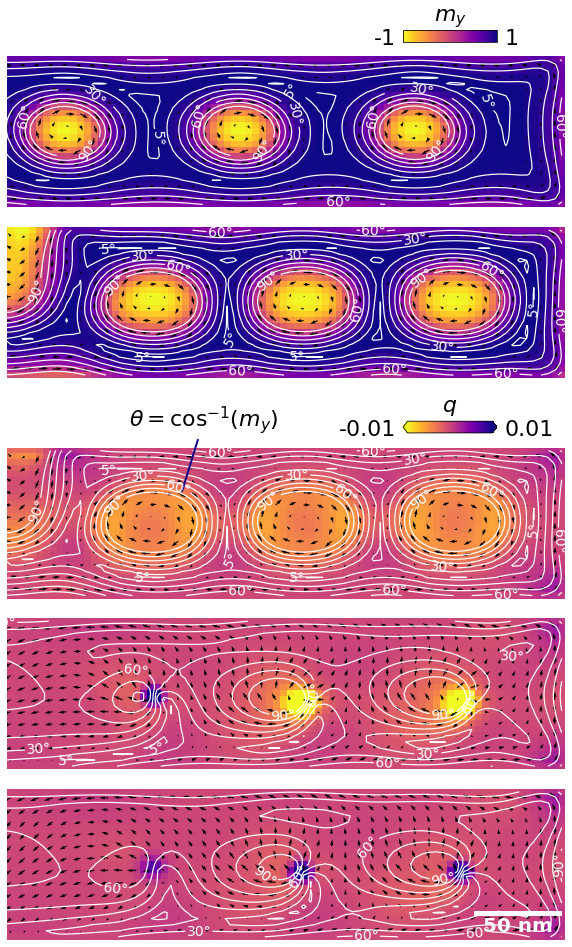

In [1131]:
f, axs = plt.subplots(ncols=1, nrows=6, figsize=(10, 5.2 * 10 / 3.2), sharex=True,
                      gridspec_kw=dict(height_ratios=[5, 5, 1, 5, 5, 5], hspace=0.15))

ax = axs.flatten()
ax[2].remove()

# Plots of m_y at 280mT and 150mT
for i, omf_index in enumerate([26, 0]):
    
    # omf_index = 26
    data = op.MagnetisationData(omfs[omf_index])
    data.generate_coordinates()
    data.generate_field()

    # Slice at -450nm (50 nm away from the surface, which is at -500 nm)
    z_index = 12
    # Numpy array Filter to get the data at the slice
    ftr = data.z == data.zs[z_index]
    bz = 150 + 5 * omf_index 

    # Plot the contour lines
    contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(6)] + [np.cos(np.pi * i / 180) for i in [5, 0]]
    C = ax[i].contour(-data.xs, -data.ys, 
                      data.mz[ftr].reshape(len(data.ys), -1), 
                      contours,
                      linewidths=1.2, colors='w')
    # contour labels
    ax[i].clabel(C, contours[::2],
                 # [np.cos(np.pi * 90 / 180), np.cos(np.pi * 30 / 180)], 
                 inline=1, fontsize=14, inline_spacing=1,
                 # fmt={np.cos(np.pi * 90 / 180): '0', np.cos(np.pi * 30 / 180): '30'}
                 # Transform the cos into grad angles to be shown:
                 fmt=lambda f: '{:.0f}'.format(round(np.arccos(f) * 180 / np.pi)) + u'°'
                 )

      # Applied field label
      # ax[i].text(0.99, 0.02, ' {} mT'.format(bz), transform=ax[i].transAxes,  
      #            fontsize=24, # rotation=-90,
      #            color='white', fontweight='bold',
      #            horizontalalignment='right', verticalalignment='bottom')

    # Colorbar at top plot
    if i == 0:
        box = ax[i].get_position()
        axCb = plt.axes([box.x1 - 0.225, box.y1 + 0.0125, 0.13, 0.01])
        cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r, 
                                              orientation="horizontal",
                                              ticks=[],
                                              norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
        cb.ax.tick_params(labelsize=18) 
        cb.set_label(r'$m_{y}$', rotation=0, x=0.5, labelpad=-35, fontsize=22)
        axCb.xaxis.set_ticks_position('bottom')
        cb.set_ticklabels([])
        cb.ax.text(-0.08, 0.3, str(-1), transform=cb.ax.transAxes, va='center', ha='right', fontsize=22)
        cb.ax.text(1.08, 0.3, str(1), transform=cb.ax.transAxes, va='center', ha='left', fontsize=22)

    # pcolormesh uses the coordinates of the corners of the grid, so we must shift the
    # cell centers by (dx / 2)
    X = np.array(list(data.xs - 1e9 * 0.5 * data.dx) + [data.xs[-1] + 0.5 * 1e9 * data.dx])
    Y = np.array(list(data.ys - 1e9 * 0.5 * data.dy) + [data.ys[-1] + 0.5 * 1e9 * data.dy])
    ax[i].pcolormesh(-X, -Y, 
                   data.mz[ftr].reshape(len(data.ys), -1), 
                   # [-1 + 0.25 * i for i in range(9)],
                   # linewidth=1,
                   cmap='plasma_r', vmin=-1, vmax=1)
    
    # Quiver plots. Filter the arrows to show arrows in stride of 2 mesh positions
    qftr = np.ones_like(data.x[ftr]).astype(np.bool)
    qftr.shape = (len(data.ys), -1)
    qftr[:, ::2] = False
    qftr[::2, :] = False
    qftr.shape = (-1,)
    ax[i].quiver(-data.x[ftr][qftr], -data.y[ftr][qftr], 
                 data.field_x[ftr][qftr], data.field_y[ftr][qftr], 
                 scale=0.18, scale_units='xy', width=0.002)

    # Set the limits
    ax[i].set_xlim(180, 500)
    ax[i].set_ylim(-50, 50)
    ax[i].set_ylabel('z (nm)')

    # Remove axes
    ax[i].set_axis_off()

    # Zeros of the Average of out of plane component (not used now)
    mz_int = si.interp1d(-data.xs, bw_maps[omf_index][z_index])
    zeros = []
    a = np.linspace(200, 490, 50)
    for i, x in enumerate(a):
        try:
            zeros.append(so.brentq(mz_int, a[i], a[i + 1]))
        except: 
            pass
    print('zeros', zeros)
    
# ---------------------------------------------------------------------
# TOP CHARGES/SK NUMBER PLOTS

# We will compute q for a field of 150 mT
omf_index = 0
data = op.MagnetisationData(omfs[omf_index])
data.generate_coordinates()
data.generate_field()

# Get the range of Q number calculation
# MAX_Q, MIN_Q = 0, 0
# for i, z_index in enumerate([0, 143, 144]):
#     data.compute_sk_number(index=z_index, plane='xy')
#     ftr = data.z == data.zs[z_index]
#     minq, maxq = data.sk_number.min(), data.sk_number.max()
#     if minq < MIN_Q:
#         MIN_Q = minq
#     if maxq > MAX_Q:
#         MAX_Q = maxq
# minq, maxq = MIN_Q, MAX_Q

# We manually set the limits of the q number 
# -> we might set this automatically using the code above
minq = -0.01
maxq = -minq

# Plot slices at: -450nm, before BP, after BP
for i, z_index in enumerate([12, 143, 144]):
    # Index of axes. Axes 2 were removed to leave space
    i = i + 3
    # z_index = 144
    # Compute sk number
    q_sk = data.compute_sk_number(index=z_index, plane='xy')
    print('z_i =', z_index, 'q_sk=', q_sk)
    
    # Filter to get the data at the slice
    ftr = data.z == data.zs[z_index]
    
    # minq, maxq = data.sk_number.min(), data.sk_number.max()
    # print(z_index, minq, maxq)
    # np.max([np.abs(data.sk_number.min()), np.abs(data.sk_number.max())])

    # Contours
    ax[i].pcolormesh(-X, -Y, data.sk_number, cmap='plasma_r', 
                    vmin=minq, vmax=maxq)

    contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(6)] + [np.cos(np.pi * i / 180) for i in [5, 0]]
    C = ax[i].contour(-data.xs, -data.ys, 
                      data.mz[ftr].reshape(len(data.ys), -1), 
                      contours,
                      linewidths=1.2, colors='w',
                      )
    # Contour labels
    ax[i].clabel(C, contours[::2],
               inline=1, fontsize=14, inline_spacing=1,
               # Transform the cos into grad angles to be shown:
               fmt=lambda f: '{:.0f}'.format(round(np.arccos(f) * 180 / np.pi)) + u'°'
               )
    ax[i].set_xlim(180, 500)
    ax[i].set_ylabel('z (nm)')
    
    # We will not use these annotations for now:
    # ax[i].text(1.02, 0.5, r'$y =$' + f' {data.zs[z_index]:.0f} nm',
    #            transform=ax[i].transAxes,
    #            fontsize=22, rotation=-90,
    #            horizontalalignment='center', verticalalignment='center'
    #            )
    
    # Annotation of number at top left
    # ax[i].text(0.01, 0.98, f'{i - 2:}',
    #            transform=ax[i].transAxes,
    #            fontsize=24, color='w', fontweight='bold',
    #            horizontalalignment='left', verticalalignment='top'
    #            )

    # Applied field label
    # ax[i].text(0.99, 0.02, ' {} mT'.format(bz), transform=ax[i].transAxes,  
    #            fontsize=24, # rotation=-90,
    #            color='white', fontweight='bold',
    #            horizontalalignment='right', verticalalignment='bottom')

    # Colorbar of q number. Limits are below the extreme data values, thus
    # we show the bar with arrows to each side, using extend='both'
    if i == 3:
        box = ax[i].get_position()
        axCb = plt.axes([box.x1 - 0.225, box.y1 + 0.0125, 0.13, 0.01])
        cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r,
                                              orientation="horizontal",
                                              ticks=[], extend='both',
                                              norm=matplotlib.colors.Normalize(vmin=minq, vmax=maxq))
        cb.set_ticklabels([])
        cb.ax.tick_params(labelsize=18)
        cb.set_label(r'$q$', rotation=0, x=0.5, labelpad=-35, fontsize=22)
        axCb.xaxis.set_ticks_position('bottom')
        # just show labels at each side of the bar
        cb.ax.text(-0.08, 0.3, f'{minq}', transform=cb.ax.transAxes, va='center', ha='right', fontsize=22)
        cb.ax.text(1.08, 0.3, f'{-minq}', transform=cb.ax.transAxes, va='center', ha='left', fontsize=22)
        
    # annotation of theta angle
    if i == 3:
        ax[i].annotate(r'$\theta=\cos^{-1} (m_y)$', (280, 20), (250, 64), 
                       fontsize=22, arrowprops={'arrowstyle': '-', 'lw': 2, 'color': '#100788'})
        
    # Quiver plot
    qftr = np.ones_like(data.x[ftr]).astype(np.bool)
    qftr.shape = (len(data.ys), -1)
    qftr[:, ::2] = False
    qftr[::2, :] = False
    qftr.shape = (-1,)
    ax[i].quiver(-data.x[ftr][qftr], -data.y[ftr][qftr], 
                 data.field_x[ftr][qftr], data.field_y[ftr][qftr], 
                 scale=0.18, scale_units='xy', width=0.002)

    ax[i].set_xlim(180, 500)
    ax[i].set_ylim(-50, 50)
    ax[i].set_ylabel('z (nm)')
    
    if i == 5:
        ax[i].set_xlabel('x (nm)')
    
    # Remove the axes and only show a scale bar at the bottom plot
    ax[i].set_axis_off()
    # Scale Bar
    if i == 5:
        scalebar = AnchoredSizeBar(ax[i].transData,
                                   size=50, 
                                   label=r'50 nm', 
                                   loc='lower right', 
                                   pad=0.,
                                   color='white',
                                   frameon=False,
                                   size_vertical=2.5,
                                   borderpad=0.2,
                                   fontproperties=matplotlib.font_manager.FontProperties(size=20, weight='bold')
                                   )

        ax[i].add_artist(scalebar)


# ---------------------------------------------------------------------
# ---------------------------------------------------------------------

# plt.savefig(f'isolines_overview_mz_average_Bzs_slices.pdf',
#             bbox_inches='tight')
# plt.savefig(f'isolines_overview_mz_average_Bzs_slices.svg',
#             bbox_inches='tight')
# plt.savefig(f'isolines_overview_mz_average_Bzs_slices.png',
#             bbox_inches='tight')

plt.show()

# Sk-edge and Sk-Sk distance

Here we compute the distance between the rightmost skyrmion (after rotating the axes `y->z`, `z->y`, `x->-x`) and the edge of the sample, as a function of the applied field. Similarly, we compute the distance between the rightmost skyrmion and its adjacent skyrmion tube.

The strategy here is to use the zeros of the averages of the `m_z` component (across thickness), which coincide perfectly with the skyrmion tube centers. Thus we compute the distance of the tube using the right zeros. 
We must perform this calculation for every slice of the skyrmion tube up to the Bloch point, where the tubes end.

We first find all the zeros from the interplation to the `<mz>` average:

In [ ]:
omfs = glob.glob('sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_300mT/*.omf')
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=Magnetization-)\d\d', f).group(0)))

In [981]:
# make a dict to store the data for every field and every slice
zeros = {}
tubes_range = np.linspace(200, 495, 30)

# For every OMF file, i.e. for every field in the field sweep process
for i, oms in enumerate(omfs):
    omf_index = i
    bz = i * 5 + 150
    zeros[bz] = {}
    
    # For every slice:
    for z_index in range(145):
        # Create an empty list in the dictionary
        zeros[bz][z_index] = []

        # Interpolate the <mz> profile
        mz_int = si.interp1d(-data.xs, bw_maps[omf_index][z_index])

        # For the profile try to find all the zeros in the 200-490 range
        for i, x in enumerate(tubes_range):
            try:
                z = so.brentq(mz_int, tubes_range[i], tubes_range[i + 1])
                zeros[bz][z_index].append(z)
            except:
                pass

Now compute the distances. The sk-edge is the right edge location (at 500 nm) minus the location of the 2nd zero of `<m_z>` from the right (which is the center of the rightmost skyrmion tube).

The sk-sk distance is given by the difference of the locations of the 2nd and 4th zeros of `<m_z>` (which are the locations of the 2nd and 3rd skyrmion tube; check the isolines plot)

In [982]:
sk_edge_rightm_tube_fieldup = {}
for i, oms in enumerate(omfs[:28]):
    omf_index = i
    bz = i * 5 + 150
    sk_edge_rightm_tube_fieldup[bz] = []
    # print(bz)
    for z_index in range(144):
        try:
            # Only compute the distance when there are 6 solutions -> 3 tubes
            # There might be a better way to stop the calculation, maybe detecting where the
            # sk tube finishes
            if len(zeros[bz][z_index]) < 6:
                continue
            else:
                sk_edge_rightm_tube_fieldup[bz].append([data.zs[z_index], 500 - zeros[bz][z_index][-2]])
        except:
            # continue with next slice if there are no zero values
            continue
    sk_edge_rightm_tube_fieldup[bz] = np.array(sk_edge_rightm_tube_fieldup[bz])

# skyrion-skyrmion distance (2nd and 3rd tube)
sk_sk_rightm_tube_fieldup = {}
for i, oms in enumerate(omfs[:27]):
    omf_index = i
    bz = i * 5 + 150
    sk_sk_rightm_tube_fieldup[bz] = []
    # print(bz)
    for z_index in range(145):
        try:
            # Only compute the distance when there are 6 solutions -> 3 tubes
            if len(zeros[bz][z_index]) < 6:
                continue
            else:
                sk_sk_rightm_tube_fieldup[bz].append([data.zs[z_index], 
                                                      zeros[bz][z_index][-2] - zeros[bz][z_index][-4]])
        except:
            continue
    sk_sk_rightm_tube_fieldup[bz] = np.array(sk_sk_rightm_tube_fieldup[bz])

These are the distances between the skyrmion tube with the right edge, as a function of slice, and for different applied fields:

Text(0, 0.5, 'sk-edge distance')

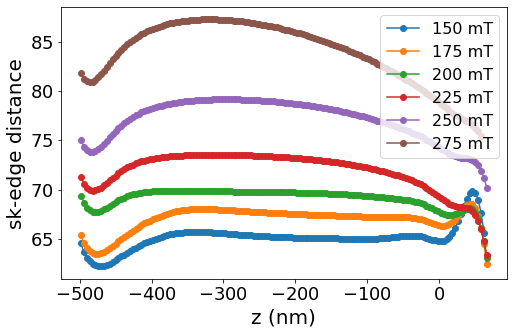

In [983]:
for bz in [150, 175, 200, 225, 250, 275]:
    plt.plot(sk_edge_rightm_tube_fieldup[bz][:, 0], 
             sk_edge_rightm_tube_fieldup[bz][:, 1], 
             'o-', label=f'{bz} mT')
    
plt.legend()
plt.xlabel('z (nm)')
plt.ylabel('sk-edge distance')

Similarly for the sk - sk distance

Text(0, 0.5, 'sk-sk distance')

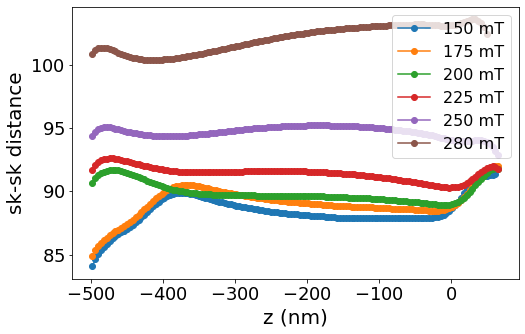

In [984]:
for bz in [150, 175, 200, 225, 250, 280]:
    plt.plot(sk_sk_rightm_tube_fieldup[bz][:, 0], 
             sk_sk_rightm_tube_fieldup[bz][:, 1], 'o-', label=f'{bz} mT')
    
plt.legend()
plt.xlabel('z (nm)')
plt.ylabel('sk-sk distance')

Here we show the tendency of s-edge distance as a box plot. Boxes show the data between the 1st and 3rd quartile. Orange lines are the mean of the data. Red dots show the average. Bars show the extent of the data up to the 1.5 size of the boxes. And points are outliers, which are outside an statistically acceptable criteria of the range where most of the data lies

The plot has a clear increasing tendency with the field. At weak fields, data is sparse, as the distance varies significantly along the tubes

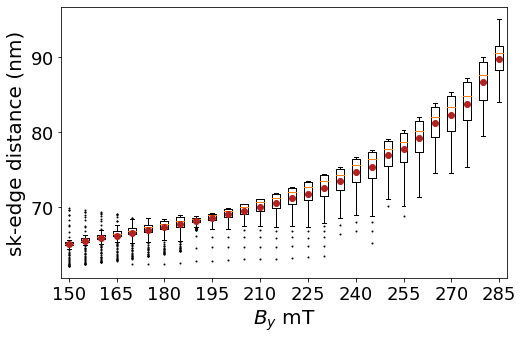

In [985]:
keys = sorted(sk_edge_rightm_tube_fieldup.keys())
plt.boxplot([sk_edge_rightm_tube_fieldup[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )
plt.xticks(range(1, len(keys) + 1)[::3], [bz for bz in keys][::3])
plt.xlabel(r'$B_y$' + ' mT')
plt.ylabel('sk-edge distance (nm)')
plt.show()

In [988]:
# Save the data
DIR = 'data_sk_edge_vs_tube-slice_Bzs'
if not os.path.exists(DIR):
    os.makedirs(DIR)

keys = sorted(sk_edge_rightm_tube_fieldup.keys())
for bz in keys:
    np.savetxt(DIR + '/' + f'sk_edge_vs_tube-slice_Bz{bz}mT.txt', sk_edge_rightm_tube_fieldup[bz])

Same for the skyrmion - skyrmion distance

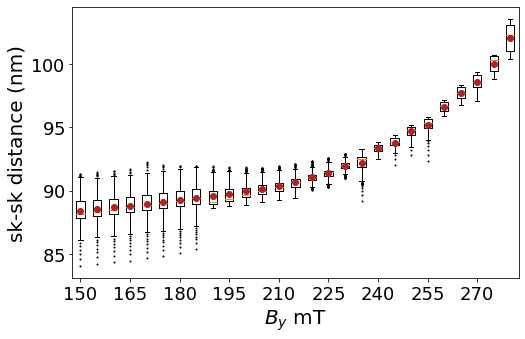

In [989]:
keys = sorted(sk_sk_rightm_tube_fieldup.keys())
plt.boxplot([sk_sk_rightm_tube_fieldup[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )
plt.xticks(range(1, len(keys) + 1)[::3], [bz for bz in keys][::3])
plt.xlabel(r'$B_y$' + ' mT')
plt.ylabel('sk-sk distance (nm)')
plt.show()

In [630]:
# Save the data
DIR = 'data_sk_sk_vs_tube-slice_Bzs'
if not os.path.exists(DIR):
    os.makedirs(DIR)

keys = sorted(sk_sk_rightm_tube_fieldup.keys())
for bz in keys:
    np.savetxt(DIR + '/' + f'sk_sk_vs_tube-slice_Bz{bz}mT.txt', sk_sk_rightm_tube_fieldup[bz])

# Field sweep: 150 mT -> 0 mT

We repeat the same data analysis for the field sweep starting at 150 mT down to 0 mT

In [1219]:
omfs = glob.glob('sims/oommf/sk_tubes_helices_FeGe_Lx1000nm_Ly100nm_Lz1000nm/field_sweep_no-helix_Bz_150mT_0mT/*.omf')
omfs = sorted(omfs, key=lambda f: int(re.search(r'(?<=Magnetization-)\d\d', f).group(0)))

In [1220]:
bw_maps = []

for i, omf in enumerate(omfs): 

    data = op.MagnetisationData(omfs[i])
    data.generate_coordinates()
    data.generate_field()
    
    av_map = np.zeros((len(data.xs), len(data.zs)))
    for j, y in enumerate(data.ys):
        fltr = data.y == data.ys[j]
        av_map += data.field_y[fltr].reshape(len(data.xs), -1)
    av_map /= len(data.ys)
        
    bw_maps.append(np.copy(av_map))

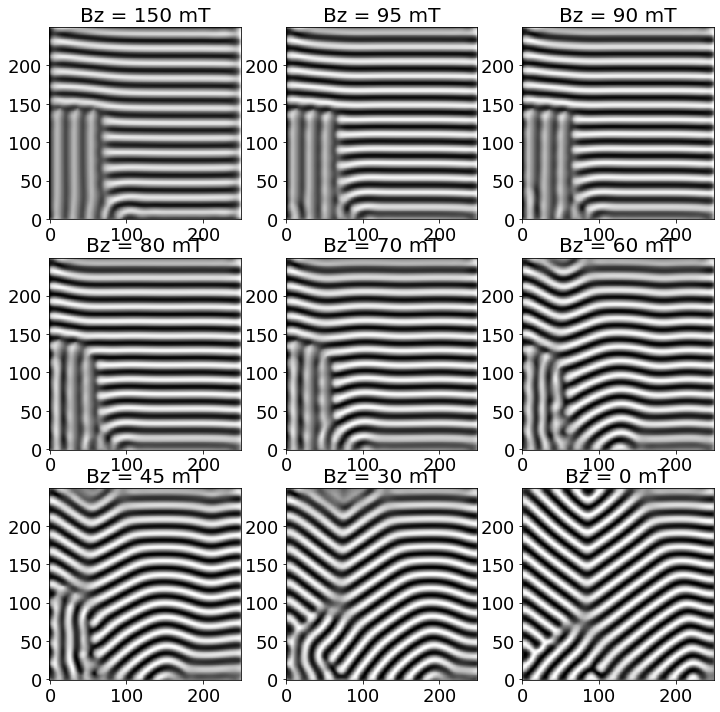

In [903]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for idx, i in enumerate([0, 11, 12, 14, 16, 18, 21, 24, 30]):
    ax = axs.flatten()[idx]
    ax.imshow(bw_maps[i], origin='lower', vmin=-1, vmax=1, cmap='binary')
    ax.set_title('Bz = {} mT'.format(150 - 5 * i))

Save the data:

In [904]:
# os.makedirs('data_my_sk_tubes_field_sweep_Bz_150mT_0mT_step_5mT')
for idx, i in enumerate(range(30)):
   
    np.savetxt('data_my_sk_tubes_field_sweep_Bz_150mT_0mT_step_5mT/m_Bz_{:03d}_mT.txt'.format(150 - 5 * i), bw_maps[i])

## Isocontours

zeros [232.67696419571683, 271.9480523731543, 312.19119434509923, 355.5384337114105, 397.9003269665044, 440.18566205335094, 480.4007607517889]


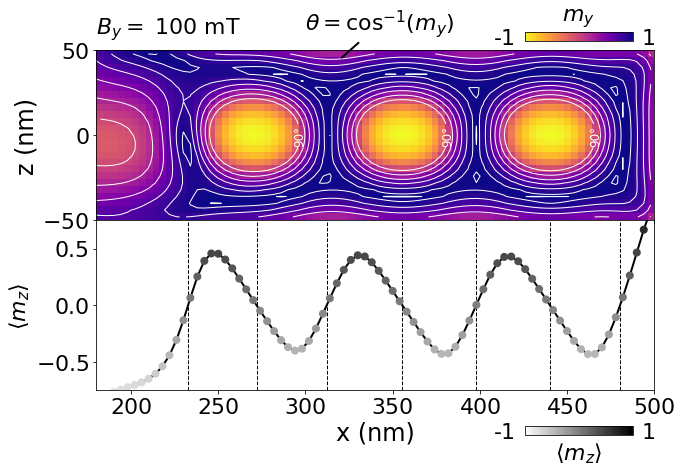

In [1225]:
omf_index = 10
data = op.MagnetisationData(omfs[omf_index])
data.generate_coordinates()
data.generate_field()

f, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 2 * 10 / 3.2), sharex=True)
plt.subplots_adjust(hspace=0.)
ax = axs.flatten()
z_index = 50
ftr = data.z == data.zs[z_index]
bz = 150 - 5 * omf_index 

# Plot the contour lines
contours = [np.cos(np.pi * (90 - 15 * i) / 180) for i in range(6)] + [np.cos(np.pi * i / 180) for i in [5, 0]]
C = ax[0].contour(-data.xs, -data.ys, 
                data.mz[ftr].reshape(len(data.ys), -1), 
                contours,
                linewidths=1., colors='w')

# If you want labels:
ax[0].clabel(C, [contours[0]],
             # [np.cos(np.pi * 90 / 180), np.cos(np.pi * 30 / 180)], 
             inline=1, fontsize=12, inline_spacing=1,
             # fmt={np.cos(np.pi * 90 / 180): '0', np.cos(np.pi * 30 / 180): '30'}
             # Transform the cos into grad angles to be shown:
             fmt=lambda f: '{:.0f}'.format(round(np.arccos(f) * 180 / np.pi)) + u'°'
             )

ax[0].annotate(r'$\theta=\cos^{-1} (m_y)$', (320, 45), (300, 62), 
               fontsize=22, arrowprops={'arrowstyle': '-', 'lw': 2, 'color': 'k'})

ax[0].text(0, 1.1, r'$B_y =$' + ' {} mT'.format(bz), transform=ax[0].transAxes,  
           fontsize=22)

# colorbar
box = ax[0].get_position()
axCb = plt.axes([box.x1 - 0.18, box.y1 + 0.02, 0.15, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.plasma_r, 
                                      orientation="horizontal",
                                      ticks=[],
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=18) 
cb.set_label(r'$m_{y}$', rotation=0, x=0.5, labelpad=-35, fontsize=22)
axCb.xaxis.set_ticks_position('top')
cb.set_ticklabels([])
cb.ax.text(-0.08, 0.3, str(-1), transform=cb.ax.transAxes, va='center', ha='right', fontsize=22)
cb.ax.text(1.08, 0.3, str(1), transform=cb.ax.transAxes, va='center', ha='left', fontsize=22)

# plt.contourf(-data.xs, -data.ys, 
#              data.mz[ftr].reshape(len(data.ys), -1), 
#              [-1 + 0.25 * i for i in range(9)],
#              linewidth=1,
#              cmap='plasma', vmin=-1, vmax=1)

# pcolormesh uses the coordinates of the corners of the grid, so we must shift the
# cell centers by (dx / 2)
X = np.array(list(data.xs - 1e9 * 0.5 * data.dx) + [data.xs[-1] + 0.5 * 1e9 * data.dx])
Y = np.array(list(data.ys - 1e9 * 0.5 * data.dy) + [data.ys[-1] + 0.5 * 1e9 * data.dy])
ax[0].pcolormesh(-X, -Y, 
               data.mz[ftr].reshape(len(data.ys), -1), 
               # [-1 + 0.25 * i for i in range(9)],
               # linewidth=1,
               cmap='plasma_r', vmin=-1, vmax=1)

ax[0].set_xlim(180, 500)
ax[0].set_ylim(-50, 50)
ax[0].set_ylabel('z (nm)')

# Show the Average of out of plane component

# We start finding the zeros of the out of plane component, by interpolating the data
mz_int = si.interp1d(-data.xs, bw_maps[omf_index][z_index])
zeros = []
# Find possible zeros analysing chunks of 50 mT of data
a = np.linspace(200, 490, 50)
for i, x in enumerate(a):
    try:
        zeros.append(so.brentq(mz_int, a[i], a[i + 1]))
    except: 
        pass
print('zeros', zeros)

# Plot the averages
ax[1].plot(-data.xs, bw_maps[omf_index][z_index], '-', c='k', lw=2, zorder=1)
ax[1].scatter(-data.xs, bw_maps[omf_index][z_index],
              c=bw_maps[omf_index][z_index],
              # 'o-', c='#100788', 
              lw=2,
              cmap='binary', vmin=-1, vmax=1, zorder=10
              )
ax[1].set_ylabel(r'$\langle m_{z} \rangle$', fontsize=22)

# plot all the zeros at vertical lines
for z in zeros:
    ax[1].axvline(x=z, lw=1, color='k', ls='--')

ax[1].set_xlabel('x (nm)')
ax[1].set_ylim(-0.75, 0.75)

# Colorbar of <m_z>
box = ax[1].get_position()
axCb = plt.axes([box.x1 - 0.18, box.y0 - 0.1, 0.15, 0.02])
cb = matplotlib.colorbar.ColorbarBase(axCb, cmap=plt.cm.binary, 
                                              orientation="horizontal",
                                              ticks=[],
                                              norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.ax.tick_params(labelsize=18) 
cb.set_label(r'$\langle m_z \rangle$', rotation=0, x=0.5, labelpad=5, fontsize=22)
axCb.xaxis.set_ticks_position('bottom')
cb.set_ticklabels([])
cb.ax.text(-0.08, 0.3, str(-1), transform=cb.ax.transAxes, va='center', ha='right', fontsize=22)
cb.ax.text(1.08, 0.3, str(1), transform=cb.ax.transAxes, va='center', ha='left', fontsize=22)

plt.savefig(f'isolines_mz_average_Bz{bz:04d}mT_z-slice{int(data.zs[z_index])}nm.pdf',
            bbox_inches='tight')

plt.show()

## Sk-sk and sk-edge distance 

In [910]:
150 - 5 * 10

100

In [998]:
# z_index = 0
# omf_index = 26

zeros = {}
tubes_range = np.linspace(200, 495, 30)

# For every OMF file, i.e. for every field in the field sweep process
for i, oms in enumerate(omfs[:13]):
    omf_index = i
    bz = 150 - 5 * i
    zeros[bz] = {}
    
    # For every slice:
    for z_index in range(145):
        # Create an empty list in the dictionary
        zeros[bz][z_index] = []

        # Interpolate the <mz> profile
        mz_int = si.interp1d(-data.xs, bw_maps[omf_index][z_index])

        # For the profile try to find all the zeros in the 200-490 range
        for i, x in enumerate(tubes_range):
            try:
                z = so.brentq(mz_int, tubes_range[i], tubes_range[i + 1])
                zeros[bz][z_index].append(z)
            except:
                pass

In [999]:
sk_edge_rightm_tube_fielddown = {}
for i, oms in enumerate(omfs[:13]):
    omf_index = i
    bz = 150 - 5 * i
    sk_edge_rightm_tube_fielddown[bz] = []
    # print(bz)
    for z_index in range(145):
        try:
            if len(zeros[bz][z_index]) < 6:
                continue
            else:
                sk_edge_rightm_tube_fielddown[bz].append([data.zs[z_index], 
                                                          500 - zeros[bz][z_index][-2]])
        except:
            continue
    sk_edge_rightm_tube_fielddown[bz] = np.array(sk_edge_rightm_tube_fielddown[bz])

# skyrion-skyrmion distance (2nd and 3rd tube)
sk_sk_rightm_tube_fielddown = {}
for i, oms in enumerate(omfs[:13]):
    omf_index = i
    bz = 150 - 5 * i
    sk_sk_rightm_tube_fielddown[bz] = []
    # print(bz)
    for z_index in range(145):
        try:
            if len(zeros[bz][z_index]) < 6:
                # print(bz, z_index)
                continue
            else:
                sk_sk_rightm_tube_fielddown[bz].append([data.zs[z_index], 
                                                        zeros[bz][z_index][-2] - zeros[bz][z_index][-4]])
        except:
            continue
    sk_sk_rightm_tube_fielddown[bz] = np.array(sk_sk_rightm_tube_fielddown[bz])

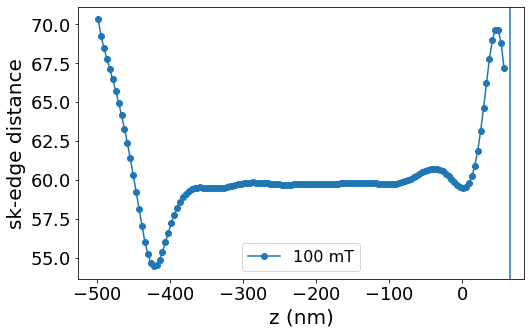

In [1000]:
for bz in [100]:
    plt.plot(sk_edge_rightm_tube_fielddown[bz][:, 0],
             sk_edge_rightm_tube_fielddown[bz][:, 1], 'o-', label=f'{bz} mT')
    
plt.legend()
plt.xlabel('z (nm)')
plt.ylabel('sk-edge distance')

plt.axvline(x=data.xs[141])

Text(0, 0.5, 'sk-sk distance')

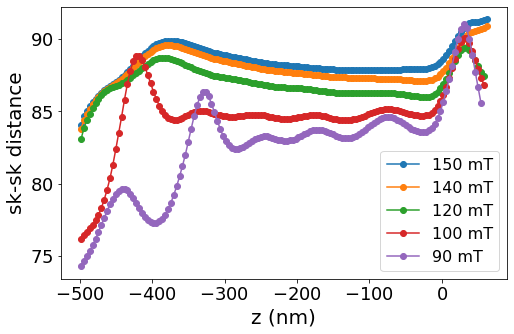

In [1001]:
for bz in [150, 140, 120, 100, 90]:
    plt.plot(sk_sk_rightm_tube_fielddown[bz][:, 0], 
             sk_sk_rightm_tube_fielddown[bz][:, 1], 'o-', label=f'{bz} mT')
    
plt.legend()
plt.xlabel('z (nm)')
plt.ylabel('sk-sk distance')

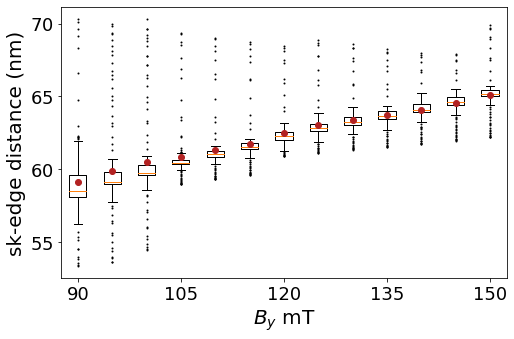

In [1002]:
keys = sorted(sk_edge_rightm_tube_fielddown.keys())
plt.boxplot([sk_edge_rightm_tube_fielddown[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )
plt.xticks(range(1, len(keys) + 1)[::3], [bz for bz in keys][::3])
plt.xlabel(r'$B_y$' + ' mT')
plt.ylabel('sk-edge distance (nm)')
plt.show()

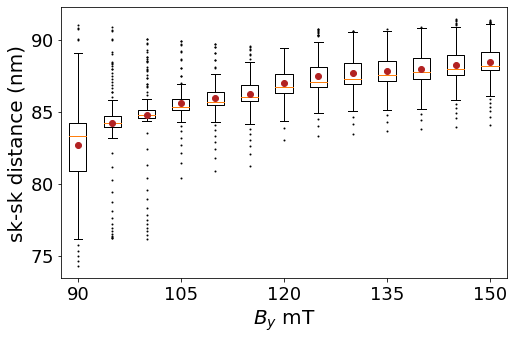

In [971]:
keys = sorted(sk_sk_rightm_tube_fielddown.keys())
plt.boxplot([sk_sk_rightm_tube_fielddown[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )
plt.xticks(range(1, len(keys) + 1)[::3], [bz for bz in keys][::3])
plt.xlabel(r'$B_y$' + ' mT')
plt.ylabel('sk-sk distance (nm)')
plt.show()

In [1006]:
# Save the data
DIR = 'data_sk_sk_vs_tube-slice_Bzs'
if not os.path.exists(DIR):
    os.makedirs(DIR)

keys = sorted(sk_sk_rightm_tube_fielddown.keys())
for bz in keys:
    np.savetxt(DIR + '/' + f'sk_sk_vs_tube-slice_Bz{bz}mT.txt', sk_sk_rightm_tube_fielddown[bz])
    
DIR = 'data_sk_edge_vs_tube-slice_Bzs'
if not os.path.exists(DIR):
    os.makedirs(DIR)

keys = sorted(sk_edge_rightm_tube_fielddown.keys())
for bz in keys:
    np.savetxt(DIR + '/' + f'sk_edge_vs_tube-slice_Bz{bz}mT.txt', sk_edge_rightm_tube_fielddown[bz])

# Combined sk-edge and sk-sk distance

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9c5dc8ff28>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9c5dc9b5f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9c5dc872e8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9c5dc9bc88>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9c5dca6320>],
 'means': [<matplotlib.lines.Line2D at 0x7f9c5dc9bfd0>]}

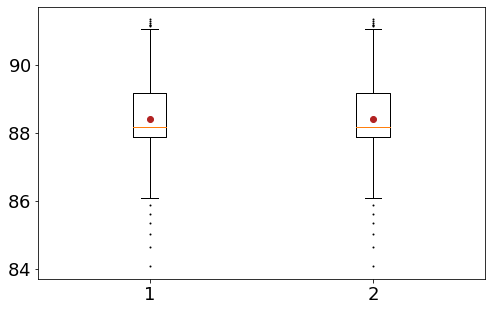

In [992]:
plt.boxplot(sk_sk_rightm_tube_fieldup[150][:, 1],
            # positions=[bz for bz in rightm_tube.keys()],
            # labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )

plt.boxplot(sk_sk_rightm_tube_fielddown[150][:, 1],
            positions=[2],
            # labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )

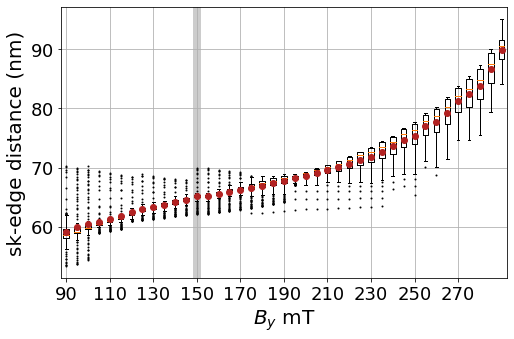

In [1007]:
keys = sorted(sk_edge_rightm_tube_fieldup.keys())
plt.boxplot([sk_edge_rightm_tube_fieldup[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )

keysd = sorted(sk_edge_rightm_tube_fielddown.keys())
plt.boxplot([sk_edge_rightm_tube_fielddown[bz][:, 1] for bz in keysd],
            positions=np.arange(-len(keysd) + 1, 1),
            labels=[bz for bz in keysd],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )

n_ticks = np.arange(-len(keysd) + 1 , len(keys))
plt.xticks(n_ticks[::4], [150 + i * 5 for i in n_ticks][::4])
plt.xlabel(r'$B_y$' + ' mT')
plt.ylabel('sk-edge distance (nm)')

plt.axvline(x=0, zorder=0, color='k', alpha=0.2, lw=8)
plt.grid()

plt.savefig(f'sk_edge_distances_field_sweep.pdf',
            bbox_inches='tight')

plt.show()

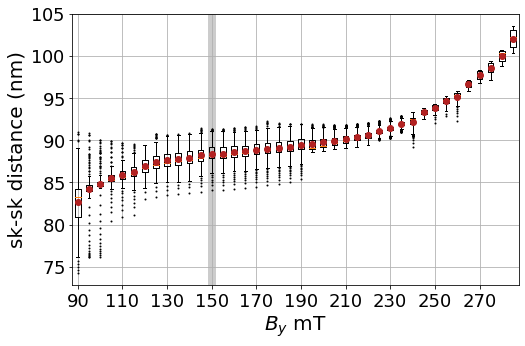

In [1008]:
keys = sorted(sk_sk_rightm_tube_fieldup.keys())
plt.boxplot([sk_sk_rightm_tube_fieldup[bz][:, 1] for bz in keys],
            # positions=[bz for bz in rightm_tube.keys()],
            labels=[bz for bz in keys],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )

keysd = sorted(sk_sk_rightm_tube_fielddown.keys())
plt.boxplot([sk_sk_rightm_tube_fielddown[bz][:, 1] for bz in keysd],
            positions=np.arange(-len(keysd) + 1, 1),
            labels=[bz for bz in keysd],
            flierprops={'markersize': 1},
            showmeans=True, meanprops=dict(marker='o', markeredgecolor='firebrick', markerfacecolor='firebrick')
            )

n_ticks = np.arange(-len(keysd) + 1 , len(keys))
plt.xticks(n_ticks[::4], [150 + i * 5 for i in n_ticks][::4])
plt.xlabel(r'$B_y$' + ' mT')
plt.ylabel('sk-sk distance (nm)')

plt.axvline(x=0, zorder=0, color='k', alpha=0.2, lw=8)
plt.grid()

plt.savefig(f'sk_sk_distances_field_sweep.pdf',
            bbox_inches='tight')

plt.show()